## Libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

In [3]:
from src.Player2Vec import Player2Vec, EPL_Graph

/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.bayesian_PSL import PlayerComparison, RandomVariablePSL, TeamPSL, EPL_Data

In [5]:
import pandas as pd
from scipy import stats
import numpy as np

In [6]:
from tqdm import tqdm

In [7]:
import warnings

warnings.filterwarnings("ignore")

In [8]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Pre-Data

In [9]:
N_MATCHES = 190

In [10]:
EPL_Full_Data = EPL_Data(
    "../SampleData/epl.xlsx", "../SampleData/players.json", "R_storage.npy"
)

# epl = EPL_Full_Data.get_epl()
# epl_player_data = EPL_Full_Data.get_epl_player_data()
# R_storage = EPL_Full_Data.get_r_storage()
# Q_storage = EPL_Full_Data.get_q_storage()
# partidos = EPL_Full_Data.get_partidos()
# tp_ds = EPL_Full_Data.get_transition_prob_dataset()
# player_ids = EPL_Full_Data.get_player_ids()
# player_kdes = EPL_Full_Data.get_player_kdes()

## Graph

In [ ]:
epl_graph = EPL_Graph(EPL_Full_Data)
_ = epl_graph.build_graph(use_Q=False, weight_player_to_state=True, n_matches=N_MATCHES)

In [ ]:
# model_path = "EPL_Graph_model_3_Weight_Duration_Q.model"
# model_path = "./batch_p2v/64_100_500_20/64_100_500_20.model"
p2v_model = Player2Vec(epl_data=EPL_Full_Data)
p2v_model.train(
    epl_graph.graph, dimensions=64, window=30, num_walks=500, walk_length=40
)

In [ ]:
p2v_model.export_embeddings_json(f"{N_MATCHES}_matches_64_30_500_40.json")

In [ ]:
p2v_model.save_model(f"{N_MATCHES}_matches_64_30_500_40.model")

In [12]:
epl_graph.save_graph(f"{N_MATCHES}_matches_64_30_500_40.pkl")

NameError: name 'epl_graph' is not defined

## Load P2V

In [11]:
p2v_model = Player2Vec(
    epl_data=EPL_Full_Data, model_path=f"{N_MATCHES}_matches_64_30_500_40.model"
)

## Transition Dataset

In [13]:
tp_ds = EPL_Full_Data.build_transition_prob_dataset()
tp_ds.columns

Index(['player_id', 'team_id', 'team_index', 'match_id', 'match_num',
       'lineup_index', 'duration', 'gains_prob', 'losses_prob', 'shots_prob',
       'avg_pass_to_prob', 'avg_pass_from_prob', 'pass_to_0', 'pass_to_1',
       'pass_to_2', 'pass_to_3', 'pass_to_4', 'pass_to_5', 'pass_to_6',
       'pass_to_7', 'pass_to_8', 'pass_to_9', 'pass_to_10', 'pass_from_0',
       'pass_from_1', 'pass_from_2', 'pass_from_3', 'pass_from_4',
       'pass_from_5', 'pass_from_6', 'pass_from_7', 'pass_from_8',
       'pass_from_9', 'pass_from_10'],
      dtype='object')

In [14]:
tp_ds = tp_ds[tp_ds["player_id"] != 0.0]
tp_ds

,player_id,team_id,team_index,match_id,match_num,lineup_index,duration,gains_prob,losses_prob,shots_prob,...,pass_from_1,pass_from_2,pass_from_3,pass_from_4,pass_from_5,pass_from_6,pass_from_7,pass_from_8,pass_from_9,pass_from_10
2,17733.0,3,0,441999,0,0,62.016667,0.035714,0.345238,0.023810,...,0.035714,0.000000,0.000000,0.080000,0.109890,0.168831,0.353846,0.023256,0.034091,0.375
3,19524.0,3,0,441999,0,0,62.016667,0.024096,0.168675,0.012048,...,0.095238,0.060241,0.000000,0.066667,0.032967,0.025974,0.030769,0.000000,0.011364,0.000
4,15943.0,3,0,441999,0,0,62.016667,0.028571,0.485714,0.028571,...,0.071429,0.012048,0.200000,0.013333,0.076923,0.012987,0.276923,0.069767,0.056818,0.000
5,20467.0,3,0,441999,0,0,62.016667,0.013333,0.306667,0.013333,...,0.095238,0.144578,0.085714,0.106667,0.000000,0.142857,0.107692,0.046512,0.170455,0.000
6,80254.0,3,0,441999,0,0,62.016667,0.032967,0.142857,0.000000,...,0.095238,0.120482,0.085714,0.040000,0.065934,0.000000,0.015385,0.162791,0.068182,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41918,74235.0,111,1,442378,379,3,93.016667,0.000000,0.500000,0.000000,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
41919,106458.0,111,1,442378,379,3,93.016667,0.000000,0.333333,0.000000,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
41920,76227.0,111,1,442378,379,3,93.016667,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
41921,50471.0,111,1,442378,379,3,93.016667,0.000000,1.000000,0.000000,...,1.000000,0.166667,0.333333,0.833333,0.000000,0.500000,0.500000,0.333333,0.500000,1.000


In [15]:
tp_ds_last = tp_ds[tp_ds["match_num"] >= N_MATCHES]

# player_kdes_last = RandomVariablePSL.calculate_player_kdes(tp_ds_last, EPL_Full_Data.get_player_ids())
tp_ds_last

,player_id,team_id,team_index,match_id,match_num,lineup_index,duration,gains_prob,losses_prob,shots_prob,...,pass_from_1,pass_from_2,pass_from_3,pass_from_4,pass_from_5,pass_from_6,pass_from_7,pass_from_8,pass_from_9,pass_from_10
21122,17733.0,3,0,442189,190,0,72.016667,0.166667,0.383333,0.000000,...,0.000000,0.000000,0.086207,0.017241,0.021739,0.037736,0.028986,0.000000,0.033333,0.147059
21123,54102.0,3,0,442189,190,0,72.016667,0.000000,0.457143,0.000000,...,0.116667,0.057143,0.000000,0.103448,0.043478,0.000000,0.086957,0.000000,0.100000,0.058824
21124,15943.0,3,0,442189,190,0,72.016667,0.068966,0.241379,0.000000,...,0.066667,0.000000,0.051724,0.000000,0.021739,0.075472,0.231884,0.066667,0.150000,0.000000
21125,8758.0,3,0,442189,190,0,72.016667,0.000000,0.534483,0.017241,...,0.016667,0.028571,0.051724,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000
21126,81880.0,3,0,442189,190,0,72.016667,0.108696,0.500000,0.021739,...,0.066667,0.257143,0.103448,0.034483,0.000000,0.000000,0.072464,0.000000,0.000000,0.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41918,74235.0,111,1,442378,379,3,93.016667,0.000000,0.500000,0.000000,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41919,106458.0,111,1,442378,379,3,93.016667,0.000000,0.333333,0.000000,...,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41920,76227.0,111,1,442378,379,3,93.016667,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41921,50471.0,111,1,442378,379,3,93.016667,0.000000,1.000000,0.000000,...,1.000000,0.166667,0.333333,0.833333,0.000000,0.500000,0.500000,0.333333,0.500000,1.000000


In [16]:
# Count ammount of zeros in the dataset
section_last = tp_ds_last[[col for col in tp_ds_last.columns if "prob" in col]]
section_last = section_last.replace(0.0, np.nan)
section_last.isnull().sum().sum(), section_last.shape[0] * section_last.shape[
    1
], section_last.isnull().sum().sum() / (section_last.shape[0] * section_last.shape[1])

(25282, 69340, 0.36460917219498123)

In [17]:
player_stats_last = RandomVariablePSL.calculate_player_stats(
    tp_ds_last, EPL_Full_Data.get_player_ids()
)

flat_stats_df = pd.DataFrame(player_stats_last).T
flat_stats_df

mean       std       min       max
17733.0  losses_prob         0.522438  0.245700  0.142857  1.000000
         gains_prob          0.056407  0.098543  0.000000  0.333333
         shots_prob          0.006427  0.018494  0.000000  0.083333
         avg_pass_to_prob    0.042830  0.022293  0.000000  0.077922
         avg_pass_from_prob  0.075969  0.096961  0.000000  0.396212
...                               ...       ...       ...       ...
106458.0 losses_prob         0.333333       NaN  0.333333  0.333333
         gains_prob          0.000000       NaN  0.000000  0.000000
         shots_prob          0.000000       NaN  0.000000  0.000000
         avg_pass_to_prob    0.060606       NaN  0.060606  0.060606
         avg_pass_from_prob  0.015152       NaN  0.015152  0.015152

[2605 rows x 4 columns]

In [18]:
flat_stats_df.columns

# Index(['mean', 'std'], dtype='object')

Index(['mean', 'std', 'min', 'max'], dtype='object')

In [19]:
flat_stats_df.index

"""
MultiIndex([(     0,        'losses_prob'),
            (     0,         'gains_prob'),
            (     0,         'shots_prob'),
            (     0,   'avg_pass_to_prob'),
            (     0, 'avg_pass_from_prob'),
            ( 17733,        'losses_prob'),
            ( 17733,         'gains_prob'),
            ( 17733,         'shots_prob'),
            ( 17733,   'avg_pass_to_prob'),
            ( 17733, 'avg_pass_from_prob'),
            ...
"""

"\nMultiIndex([(     0,        'losses_prob'),\n            (     0,         'gains_prob'),\n            (     0,         'shots_prob'),\n            (     0,   'avg_pass_to_prob'),\n            (     0, 'avg_pass_from_prob'),\n            ( 17733,        'losses_prob'),\n            ( 17733,         'gains_prob'),\n            ( 17733,         'shots_prob'),\n            ( 17733,   'avg_pass_to_prob'),\n            ( 17733, 'avg_pass_from_prob'),\n            ...\n"

In [20]:
vals_arr = np.array(flat_stats_df.values.flatten(), dtype=np.float64)
np.nanmean(vals_arr), np.nanstd(vals_arr), np.nansum(vals_arr)

(0.14346563236475907, 0.2448567725222336, 1479.130669680666)

In [21]:
player_ids = EPL_Full_Data.get_player_ids()
player_ids.astype(int)

array([     0,  17733,  19524,  15943,  20467,  80254,   8758,  42427,
        17127,  43274,  28566,  59936,  44346,  41792,  13227,  34392,
        15073,  63370,  17468,  19057,  28468,  28541,   3736,  66797,
        28448,  58771,   4396,  37339,  53371,  62419,  41184,  27707,
        12745,   7525,   8378,   6219,  15337,   1821,   9007,   7645,
        59949,  18981,  20695,  14965,  51940,  13017,  14075,  38530,
          363,  50175,   2404,  43250,  83090,  12297,  18892,  27258,
         4098,   1869,  37084,   4990,  39104,  15284,  11987,   1827,
        17160,  42518,   1256,  37334,  81025,  11735,  40451,  38297,
        19569,  19341,   5741,  18987,  19124,  41727,  15864,  15237,
        19236,  40204,  41262,  28499,  18421,  44683,  39155,  42774,
        19197,  15976,   3673,  57328, 101178,  17291,  38580,  11037,
        17339,  18867,  37572,  20312,  14664,  49384,  17476,   7551,
        15749,  20658,  20664,  28554,  17336,  42544,  42493,  42593,
      

In [22]:
emb_df = pd.DataFrame(
    {
        player_id: {
            "player_id": player_id,
            **{
                f"emb_{i}": (p2v_model.model.wv.get_vector(str(player_id))[i])
                for i in range(3)
            },
        }
        for i, player_id in tqdm(
            enumerate(player_ids.astype(int)), total=len(player_ids)
        )
        if player_id in p2v_model.model.wv.index_to_key
    }
)

100%|██████████| 522/522 [00:15<00:00, 32.93it/s]


In [23]:
dist_ds = []

for i, player_id in tqdm(enumerate(player_ids.astype(int))):
    if str(player_id) not in p2v_model.model.wv.index_to_key:
        continue
    emb = p2v_model.model.wv.get_vector(str(player_id))

    dist_ds.append(
        {
            "player_id": player_id,
            **{f"emb_{i}": emb[i] for i in range(len(emb))},
            "losses_prob_mean": flat_stats_df.loc[(player_id, "losses_prob")]["mean"],
            "gains_prob_mean": flat_stats_df.loc[(player_id, "gains_prob")]["mean"],
            "shots_prob_mean": flat_stats_df.loc[(player_id, "shots_prob")]["mean"],
            "avg_pass_to_prob_mean": flat_stats_df.loc[(player_id, "avg_pass_to_prob")][
                "mean"
            ],
            "avg_pass_from_prob_mean": flat_stats_df.loc[
                (player_id, "avg_pass_from_prob")
            ]["mean"],
            "losses_prob_std": flat_stats_df.loc[(player_id, "losses_prob")]["std"],
            "gains_prob_std": flat_stats_df.loc[(player_id, "gains_prob")]["std"],
            "shots_prob_std": flat_stats_df.loc[(player_id, "shots_prob")]["std"],
            "avg_pass_to_prob_std": flat_stats_df.loc[(player_id, "avg_pass_to_prob")][
                "std"
            ],
            "avg_pass_from_prob_std": flat_stats_df.loc[
                (player_id, "avg_pass_from_prob")
            ]["std"],
            # **{
            #     f"{d}_{s}_mean": flat_stats_df.loc[(player_id, s)]["mean"]
            #     for d, s in flat_stats_df.index
            # },
            # **{
            #     f"{d}_{s}_std": flat_stats_df.loc[(player_id, s)]["std"]
            #     for d, s in flat_stats_df.index
            # },
            # "name": EPL_Full_Data.epl_player_data.get_player_name(int(player_id)),
            # "position": EPL_Full_Data.epl_player_data.get_player_position(
            #     int(player_id)
            # ),
            # "team": EPL_Full_Data.get_player_team(int(player_id)),
        }
    )

dist_ds

522it [00:00, 1596.37it/s]


[{'player_id': 17733,
  'emb_0': -0.7772358,
  'emb_1': -0.82739365,
  'emb_2': -1.1085166,
  'emb_3': -1.3674924,
  'emb_4': 0.29804724,
  'emb_5': 0.10072183,
  'emb_6': 0.3333551,
  'emb_7': -0.25768927,
  'emb_8': -0.41519338,
  'emb_9': 1.1177084,
  'emb_10': -0.3047331,
  'emb_11': -0.12008282,
  'emb_12': 0.6120322,
  'emb_13': 0.21611778,
  'emb_14': -0.5046048,
  'emb_15': 0.2669434,
  'emb_16': 0.23370188,
  'emb_17': -1.2523266,
  'emb_18': 0.7469084,
  'emb_19': -2.0202281,
  'emb_20': 0.48876593,
  'emb_21': 1.67743,
  'emb_22': -0.59618044,
  'emb_23': -0.092930004,
  'emb_24': -0.62694,
  'emb_25': 1.2188017,
  'emb_26': 1.2672791,
  'emb_27': 1.2358103,
  'emb_28': -0.46536264,
  'emb_29': -1.0884738,
  'emb_30': -0.23690185,
  'emb_31': -0.7723991,
  'emb_32': 1.024458,
  'emb_33': -0.8763858,
  'emb_34': -0.7981867,
  'emb_35': 0.2050004,
  'emb_36': -1.7812711,
  'emb_37': 1.0273848,
  'emb_38': 0.4147971,
  'emb_39': 0.79532295,
  'emb_40': -0.30189267,
  'emb_41': 

In [24]:
dist_df = pd.DataFrame(dist_ds)
dist_df

,player_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,losses_prob_mean,gains_prob_mean,shots_prob_mean,avg_pass_to_prob_mean,avg_pass_from_prob_mean,losses_prob_std,gains_prob_std,shots_prob_std,avg_pass_to_prob_std,avg_pass_from_prob_std
0,17733,-0.777236,-0.827394,-1.108517,-1.367492,0.298047,0.100722,0.333355,-0.257689,-0.415193,...,0.522438,0.056407,0.006427,0.042830,0.075969,0.245700,0.098543,0.018494,0.022293,0.096961
1,19524,-0.197837,-0.086181,-0.270440,-1.541033,-0.647647,-0.241033,0.453066,0.031506,-0.255329,...,0.476905,0.060310,0.008371,0.045140,0.063593,0.270918,0.079496,0.026923,0.024852,0.078595
2,15943,-0.517551,-0.757132,-0.763548,-1.837337,-0.012568,-0.121198,0.069757,0.380025,-0.557337,...,0.473276,0.025076,0.002232,0.041188,0.049214,0.299080,0.044807,0.011811,0.027108,0.106616
3,20467,0.059738,-0.997576,0.113130,-1.064545,-0.540343,0.934796,0.413289,0.402721,-0.467876,...,0.559636,0.046652,0.016917,0.036475,0.140044,0.304517,0.090823,0.054031,0.027746,0.178373
4,80254,-0.975766,0.388918,-0.581350,-1.586341,-0.943228,-0.776151,0.702808,0.640583,0.382979,...,0.323336,0.036332,0.000000,0.061515,0.044705,0.254415,0.082949,0.000000,0.023129,0.031851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,103912,0.006345,-0.008638,-0.014481,0.010936,0.007477,-0.001648,-0.004203,-0.005378,0.014359,...,0.505882,0.047059,0.070588,0.038503,0.070922,NaN,NaN,NaN,NaN,NaN
517,92790,0.007155,-0.004274,-0.010602,-0.012365,0.013518,-0.006678,0.006705,-0.007051,0.007838,...,0.557500,0.110000,0.000000,0.040227,0.015298,0.250708,0.220000,0.000000,0.022792,0.020905
518,94738,-0.014298,0.000599,0.004172,-0.001862,0.005824,0.001945,-0.000426,-0.003270,-0.014652,...,0.583333,0.000000,0.000000,0.037879,0.011364,0.117851,0.000000,0.000000,0.010714,0.000000
519,76227,0.014679,0.000733,-0.000395,0.001490,-0.000436,0.011961,-0.007276,-0.000852,-0.013699,...,0.500000,0.000000,0.000000,0.045455,0.040748,0.000000,0.000000,0.000000,0.000000,0.036199


In [25]:
dist_df = dist_df.fillna(0)
dist_df

,player_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,losses_prob_mean,gains_prob_mean,shots_prob_mean,avg_pass_to_prob_mean,avg_pass_from_prob_mean,losses_prob_std,gains_prob_std,shots_prob_std,avg_pass_to_prob_std,avg_pass_from_prob_std
0,17733,-0.777236,-0.827394,-1.108517,-1.367492,0.298047,0.100722,0.333355,-0.257689,-0.415193,...,0.522438,0.056407,0.006427,0.042830,0.075969,0.245700,0.098543,0.018494,0.022293,0.096961
1,19524,-0.197837,-0.086181,-0.270440,-1.541033,-0.647647,-0.241033,0.453066,0.031506,-0.255329,...,0.476905,0.060310,0.008371,0.045140,0.063593,0.270918,0.079496,0.026923,0.024852,0.078595
2,15943,-0.517551,-0.757132,-0.763548,-1.837337,-0.012568,-0.121198,0.069757,0.380025,-0.557337,...,0.473276,0.025076,0.002232,0.041188,0.049214,0.299080,0.044807,0.011811,0.027108,0.106616
3,20467,0.059738,-0.997576,0.113130,-1.064545,-0.540343,0.934796,0.413289,0.402721,-0.467876,...,0.559636,0.046652,0.016917,0.036475,0.140044,0.304517,0.090823,0.054031,0.027746,0.178373
4,80254,-0.975766,0.388918,-0.581350,-1.586341,-0.943228,-0.776151,0.702808,0.640583,0.382979,...,0.323336,0.036332,0.000000,0.061515,0.044705,0.254415,0.082949,0.000000,0.023129,0.031851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,103912,0.006345,-0.008638,-0.014481,0.010936,0.007477,-0.001648,-0.004203,-0.005378,0.014359,...,0.505882,0.047059,0.070588,0.038503,0.070922,0.000000,0.000000,0.000000,0.000000,0.000000
517,92790,0.007155,-0.004274,-0.010602,-0.012365,0.013518,-0.006678,0.006705,-0.007051,0.007838,...,0.557500,0.110000,0.000000,0.040227,0.015298,0.250708,0.220000,0.000000,0.022792,0.020905
518,94738,-0.014298,0.000599,0.004172,-0.001862,0.005824,0.001945,-0.000426,-0.003270,-0.014652,...,0.583333,0.000000,0.000000,0.037879,0.011364,0.117851,0.000000,0.000000,0.010714,0.000000
519,76227,0.014679,0.000733,-0.000395,0.001490,-0.000436,0.011961,-0.007276,-0.000852,-0.013699,...,0.500000,0.000000,0.000000,0.045455,0.040748,0.000000,0.000000,0.000000,0.000000,0.036199


## Torch

In [61]:
class p2v_dist_model(nn.Module):
    def __init__(self, input_size=3, output_size=10):
        super(p2v_dist_model, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [62]:
class JSD(nn.Module):
    """Jenson-Shannon Divergence Loss Function

    https://discuss.pytorch.org/t/jensen-shannon-divergence/2626/13
    """

    def __init__(self):
        super(JSD, self).__init__()
        self.kl = nn.KLDivLoss(reduction="batchmean", log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        """
        p: torch.tensor
            Tensor of shape (batch_size, n_classes)
        q: torch.tensor
            Tensor of shape (batch_size, n_classes)

        Returns
        -------
        torch.tensor
            Jenson-Shannon Divergence between p and q
        """

        p, q = p.view(-1, p.size(-1)).log_softmax(-1), q.view(
            -1, q.size(-1)
        ).log_softmax(-1)
        m = 0.5 * (p + q)
        return 0.5 * (self.kl(m, p) + self.kl(m, q))


# output_cols
"""
[
   0 'losses_prob_mean',
   1 'gains_prob_mean',
   2 'shots_prob_mean',
   3 'avg_pass_to_prob_mean',
   4 'avg_pass_from_prob_mean',
   5 'losses_prob_std',
   6 'gains_prob_std',
   7 'shots_prob_std',
   8 'avg_pass_to_prob_std',
   9 'avg_pass_from_prob_std'
]
"""

# 0, 5 -> losses mean, std
# 1, 6 -> gains mean, std
# 2, 7 -> shots mean, std
# 3, 8 -> avg pass to mean, std
# 4, 9 -> avg pass from mean, std

# Custom loss function to calculate the Jensen-Shannon Divergence between the predicted and target distributions for the 5 features
# Ponderation of the divergence of the mean and std of the 5 features


class custom_loss(nn.Module):
    def __init__(self):
        super(custom_loss, self).__init__()
        self.jsd = JSD()

    def forward(self, y_pred, y_true):
        loss = 0
        for i in range(5):
            loss += self.jsd(y_pred[:, i], y_true[:, i]) + self.jsd(
                y_pred[:, i + 5], y_true[:, i + 5]
            )
        return loss

## Train Test Split

In [63]:
input_cols = [col for col in dist_df.columns if "emb" in col]
output_cols = [col for col in dist_df.columns if "prob" in col]

X = torch.tensor(dist_df[input_cols].values, dtype=torch.float32)
y = torch.tensor(
    dist_df[[col for col in dist_df.columns if "prob" in col]].values,
    dtype=torch.float32,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the input data

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)

X_test_scaled = scaler_x.transform(X_test)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

# Scale the output data
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_train_scaled = torch.tensor(y_train_scaled, dtype=torch.float32)

y_test_scaled = scaler_y.transform(y_test)
y_test_scaled = torch.tensor(y_test_scaled, dtype=torch.float32)

# X_train = X_train_scaled
# y_train = y_train_scaled

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# X_test = X_test_scaled
# y_test = y_test_scaled

In [ ]:
X_train.shape, X_val.shape, X_test.shape
(torch.Size([332, 64]), torch.Size([84, 64]), torch.Size([105, 64]))

(torch.Size([332, 64]), torch.Size([84, 64]), torch.Size([105, 64]))

## Model

In [64]:
# !pip install wandb

In [65]:
import wandb

wandb.login(key="5a7fe6c819f2c71810e3e0addddfd660c3d71300")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/nacho/.netrc


True

In [66]:
model = p2v_dist_model(input_size=len(input_cols), output_size=10)
criterion = custom_loss()

lr = 0.005
momentum = 0.9
weight_decay = 0.0005

optimizer = torch.optim.SGD(
    model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

early_stopping = True
n_epochs = 10000
iterator = tqdm(range(n_epochs))

train_losses = []
test_losses = []

wandb.init(
    project="td8",
    name=f"p2v_dist_model_oos_{N_MATCHES}_for_graph_{380 - N_MATCHES}_for_model_{len(input_cols)}_{n_epochs}_{lr}_{scheduler.__class__.__name__}",
    config={
        "p2v dims": len(input_cols),
        "n_epochs": n_epochs,
        "early_stopping": early_stopping,
        "optimizer": f"{optimizer.__class__.__name__}",
        "lr": 0.01,
        "momentum": momentum,
        "weight_decay": weight_decay,
        "scheduler": f"{scheduler.__class__.__name__}",
        **{
            f"scheduler_{k}": v
            for k, v in scheduler.__dict__.items()
            if not k.startswith("_")
        },
    },
)

for epoch in iterator:
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if scheduler is not None:
        scheduler.step(loss)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        test_losses.append(loss.item())

        # early stopping
        if (
            early_stopping
            and len(test_losses) > 10
            and test_losses[-10] < test_losses[-1]
        ):
            break

    iterator.set_postfix(loss=loss.item())

    wandb.log({"train_loss": train_losses[-1], "test_loss": test_losses[-1]})

wandb.finish()

  0%|          | 0/10000 [00:00<?, ?it/s]wandb: Currently logged in as: ignacio-pardo (pardo). Use `wandb login --relogin` to force relogin


 22%|██▎       | 2250/10000 [00:26<01:29, 86.14it/s, loss=0.0151] 


test_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.01505
train_loss,0.01068


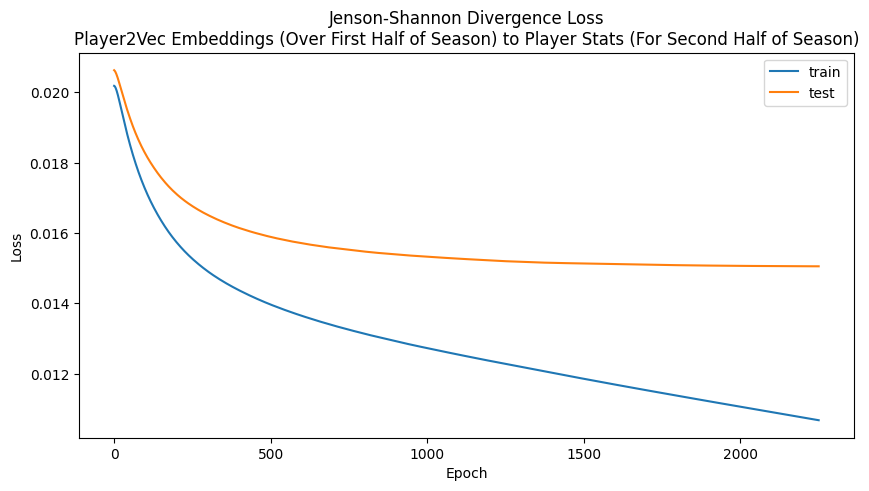

In [67]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, label="train")
ax.plot(test_losses, label="test")

ax.legend()

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax.set_title(
    "Jenson-Shannon Divergence Loss\nPlayer2Vec Embeddings (Over First Half of Season) to Player Stats (For Second Half of Season)"
)

np.argmin(test_losses), test_losses[np.argmin(test_losses)]

# Save the figure
fig.savefig(
    f"../recursos_pdf/graficos/p2v_dist_model_oos_{N_MATCHES}_for_graph_{380 - N_MATCHES}_for_model_{len(input_cols)}_{n_epochs}_{lr}_{scheduler.__class__.__name__}.png"
)

In [68]:
# !pip install hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [ ]:
# HYPERPARAMETER TUNING
gamma_choice = hp.choice("gamma", [0.1, 0.05, 0.01])
momentum_choice = hp.choice("momentum", [0.8, 0.9, 0.99])

param_grid = {
    "lr": hp.choice("lr", [0.1, 0.01, 0.001]),
    "momentum": momentum_choice,
    "weight_decay": hp.choice("weight_decay", [0.0005, 0.0001]),
    "optimizer": hp.choice(
        "optimizer",
        [
            {
                "optimizer": torch.optim.SGD,
                "params": {"momentum": momentum_choice},
            },
            {"optimizer": torch.optim.Adam, "params": {}},
            {"optimizer": torch.optim.AdamW, "params": {}},
            {
                "optimizer": torch.optim.RMSprop,
                "params": {"momentum": momentum_choice},
            },
        ],
    ),
    "scheduler": hp.choice(
        "scheduler",
        [
            {
                "scheduler": torch.optim.lr_scheduler.StepLR,
                "params": {
                    "step_size": hp.choice("step_size", [50, 100, 200]),
                    "gamma": gamma_choice,
                },
            },
            {
                "scheduler": torch.optim.lr_scheduler.MultiStepLR,
                "params": {
                    "milestones": [50, 100, 200],
                    "gamma": gamma_choice,
                },
            },
            {
                "scheduler": torch.optim.lr_scheduler.ExponentialLR,
                "params": {"gamma": gamma_choice},
            },
            {
                "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR,
                "params": {"T_max": hp.choice("T_max", [50, 100, 200])},
            },
        ],
    ),
    "early_stopping": hp.choice("early_stopping", [True]),
    "early_stopping_window": hp.choice("early_stopping_window", [10, 20, 50, 100]),
}


def objective(params):
    model = p2v_dist_model(input_size=len(input_cols), output_size=10)
    criterion = custom_loss()

    optimizer_params = params["optimizer"]["params"]
    optimizer = params["optimizer"]["optimizer"](
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"],
        **optimizer_params
    )

    scheduler_params = params["scheduler"]["params"]
    scheduler = params["scheduler"]["scheduler"](optimizer, **scheduler_params)

    early_stopping = True
    n_epochs = 10000
    # iterator = tqdm(range(n_epochs))
    iterator = range(n_epochs)

    train_losses = []
    test_losses = []

    for epoch in iterator:
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            test_losses.append(loss.item())

            # early stopping
            if (
                params["early_stopping"]
                and len(test_losses) > params["early_stopping_window"]
                and test_losses[-params["early_stopping_window"]] < test_losses[-1]
            ):
                break

    if not isinstance(np.min(test_losses), float):
        raise ValueError("Test loss is not a float value")

    return np.min(test_losses)


best = fmin(objective, param_grid, algo=tpe.suggest, max_evals=5000)

best

In [ ]:
lr_choices = [0.1, 0.01, 0.001]
momentum_choices = [0.8, 0.9, 0.99]
weight_decay_choices = [0.0005, 0.0001]
step_size_choices = [50, 100, 200]
T_max_choices = [50, 100, 200]
gamma_choices = [0.1, 0.05, 0.01]

In [ ]:
best_params = {
    "lr": lr_choices[best["lr"]],
    "momentum": momentum_choices[best["momentum"]],
    "weight_decay": weight_decay_choices[best["weight_decay"]],
    "gamma": gamma_choices[best["gamma"]],
    "step_size": step_size_choices[best["step_size"]],
    "T_max": T_max_choices[best["step_size"]],  # Si se usa CosineAnnealingLR
    "early_stopping": bool(best["early_stopping"]),
    "early_stopping_window": [10, 20, 50, 100][best["early_stopping_window"]],
    "optimizer": ["SGD", "Adam", "AdamW", "RMSprop"][best["optimizer"]],
    "scheduler": ["StepLR", "MultiStepLR", "ExponentialLR", "CosineAnnealingLR"][
        best["scheduler"]
    ],
}

best_params

In [ ]:
model = p2v_dist_model(input_size=len(input_cols), output_size=10)

criterion = custom_loss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=best_params["lr"],
    momentum=best_params["momentum"],
    weight_decay=best_params["weight_decay"],
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=best_params["step_size"], gamma=best_params["gamma"]
)

early_stopping = best_params["early_stopping"]
n_epochs = 10000
iterator = tqdm(range(n_epochs))

train_losses = []
test_losses = []

X_train_val = torch.cat([X_train, X_val], axis=0)
y_train_val = torch.cat([y_train, y_val], axis=0)

# With WANDB logging

wandb.init(
    project="td8",
    name=f"p2v_dist_model_oos_{N_MATCHES}_for_graph_{380 - N_MATCHES}_for_model_{len(input_cols)}_{n_epochs}_{lr}_{scheduler.__class__.__name__}",
    config={
        "p2v dims": len(input_cols),
        "n_epochs": n_epochs,
        "early_stopping": early_stopping,
        "optimizer": f"{optimizer.__class__.__name__}",
        "lr": 0.01,
        "momentum": momentum,
        "weight_decay": weight_decay,
        "scheduler": f"{scheduler.__class__.__name__}",
        **{
            f"scheduler_{k}": v
            for k, v in scheduler.__dict__.items()
            if not k.startswith("_")
        },
    },
)

for epoch in iterator:
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_val)
    loss = criterion(y_pred, y_train_val)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if scheduler is not None:
        scheduler.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        loss = criterion(y_pred, y_test)
        test_losses.append(loss.item())

        # early stopping
        if (
            early_stopping
            and len(test_losses) > 10
            and test_losses[-10] < test_losses[-1]
        ):
            break

    iterator.set_postfix(loss=loss.item())

    wandb.log({"train_loss": train_losses[-1], "test_loss": test_losses[-1]})

wandb.finish()

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, label="train")
ax.plot(test_losses, label="test")

ax.legend()

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax.set_title(
    "Jenson-Shannon Divergence Loss\nPlayer2Vec Embeddings (Over First Half of Season) to Player Stats (For Second Half of Season)"
)

np.argmin(test_losses), test_losses[np.argmin(test_losses)]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, label="train")
ax.plot(test_losses, label="test")

ax.legend()

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax.set_xlim(-0.01, np.argmin(test_losses) + 10)

ax.set_title(
    "Jenson-Shannon Divergence Loss\nPlayer2Vec Embeddings (Over First Half of Season) to Player Stats (For Second Half of Season)"
)

In [87]:
# HYPERPARAMETER TUNING
n_epochs = 5000

gamma_choice = hp.choice("gamma", [0.1, 0.05, 0.01])
momentum_choice = hp.choice("momentum", [0.8, 0.9, 0.99])
layer_sizes = [16, 32, 64, 128, 256, 512, 1024]

param_grid = {
    "lr": hp.choice("lr", [0.1, 0.01, 0.001]),
    "momentum": momentum_choice,
    "weight_decay": hp.choice("weight_decay", [0.0005, 0.0001]),
    "optimizer": hp.choice(
        "optimizer",
        [
            {
                "optimizer": torch.optim.SGD,
                "params": {"momentum": momentum_choice},
            },
            {"optimizer": torch.optim.Adam, "params": {}},
            {"optimizer": torch.optim.AdamW, "params": {}},
            {
                "optimizer": torch.optim.RMSprop,
                "params": {"momentum": momentum_choice},
            },
        ],
    ),
    "scheduler": hp.choice(
        "scheduler",
        [
            {
                "scheduler": torch.optim.lr_scheduler.StepLR,
                "params": {
                    "step_size": hp.choice("step_size", [50, 100, 200]),
                    "gamma": gamma_choice,
                },
            },
            {
                "scheduler": torch.optim.lr_scheduler.MultiStepLR,
                "params": {
                    "milestones": [50, 100, 200],
                    "gamma": gamma_choice,
                },
            },
            {
                "scheduler": torch.optim.lr_scheduler.ExponentialLR,
                "params": {"gamma": gamma_choice},
            },
            {
                "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR,
                "params": {"T_max": hp.choice("T_max", [50, 100, 200])},
            },
        ],
    ),
    "early_stopping_window": hp.choice("early_stopping_window", [10, 20, 50, 100]),
    "mlp": {
        "num_layers": hp.choice("num_layers", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
        "layer_sizes": [
            hp.choice(f"layer_{i}_size", layer_sizes) for i in range(10)
        ],  # Hasta 10 capas
        "activation": hp.choice("activation", [nn.ReLU, nn.LeakyReLU, nn.SiLU]),
        "dropout": hp.choice("dropout", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]),
    },
}


def create_model(input_size, output_size, num_layers, layer_sizes, activation, dropout):
    layers = []
    in_size = input_size
    for i in range(num_layers):
        layers.append(nn.Linear(in_size, layer_sizes[i]))
        layers.append(activation())
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        in_size = layer_sizes[i]
    layers.append(nn.Linear(in_size, output_size))
    return nn.Sequential(*layers)


def objective(params):
    global X_train, y_train, X_val, y_val, n_epochs

    mlp_params = params["mlp"]
    model = create_model(
        input_size=len(input_cols),
        output_size=10,
        num_layers=mlp_params["num_layers"],
        layer_sizes=mlp_params["layer_sizes"],
        activation=mlp_params["activation"],
        dropout=mlp_params["dropout"],
    )

    criterion = custom_loss()

    optimizer_params = params["optimizer"]["params"]
    optimizer = params["optimizer"]["optimizer"](
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"],
        **optimizer_params,
    )

    scheduler_params = params["scheduler"]["params"]
    scheduler = params["scheduler"]["scheduler"](optimizer, **scheduler_params)

    iterator = range(n_epochs)

    train_losses = []
    test_losses = []

    model = model.to("mps")
    X_train = X_train.to("mps")
    y_train = y_train.to("mps")
    X_val = X_val.to("mps")
    y_val = y_val.to("mps")

    for epoch in iterator:
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            test_losses.append(loss.item())

            # early stopping
            if (
                len(test_losses) > params["early_stopping_window"]
                and test_losses[-params["early_stopping_window"]] < test_losses[-1]
            ):
                break

    if not isinstance(np.min(test_losses), float):
        raise ValueError("Test loss is not a float value")

    return {
        "loss": np.min(test_losses),
        "status": STATUS_OK,
        "model": model,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "params": params,
    }


trials = Trials()
best = fmin(objective, param_grid, algo=tpe.suggest, max_evals=5000, trials=trials)

best

 19%|█▉        | 961/5000 [6:35:34<27:42:35, 24.70s/trial, best loss: 0.008916404098272324]  


KeyboardInterrupt: 

In [70]:
def plot_losses(train_losses, test_losses):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(train_losses, label="Train Loss")
    ax.plot(test_losses, label="Val Loss")

    ax.legend()

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

    ax.set_title(
        "Jenson-Shannon Divergence Loss\nPlayer2Vec Embeddings (Over First Half of Season) to Player Stats (For Second Half of Season)"
    )

    return fig, ax

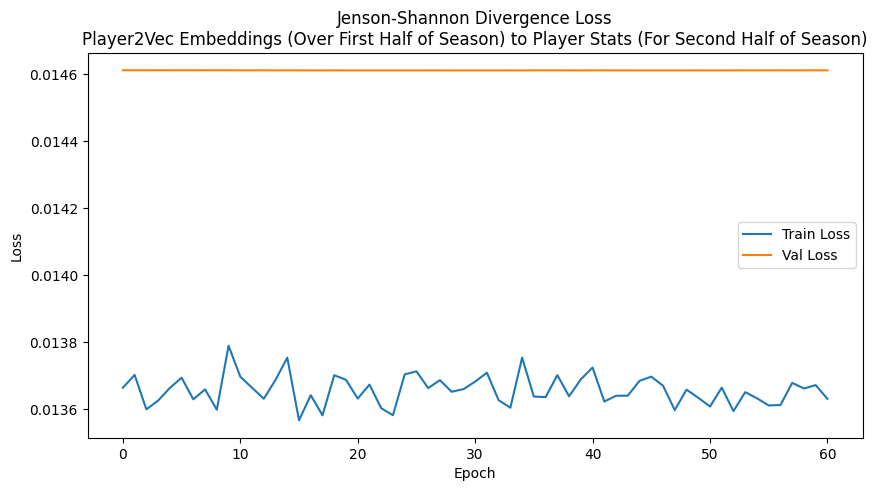

In [71]:
t_i = 4
_ = plot_losses(trials.results[t_i]["train_losses"], trials.results[t_i]["test_losses"])

{'loss': 0.008916404098272324,
 'status': 'ok',
 'model': Sequential(
   (0): Linear(in_features=64, out_features=1024, bias=True)
   (1): LeakyReLU(negative_slope=0.01)
   (2): Dropout(p=0.3, inplace=False)
   (3): Linear(in_features=1024, out_features=256, bias=True)
   (4): LeakyReLU(negative_slope=0.01)
   (5): Dropout(p=0.3, inplace=False)
   (6): Linear(in_features=256, out_features=64, bias=True)
   (7): LeakyReLU(negative_slope=0.01)
   (8): Dropout(p=0.3, inplace=False)
   (9): Linear(in_features=64, out_features=256, bias=True)
   (10): LeakyReLU(negative_slope=0.01)
   (11): Dropout(p=0.3, inplace=False)
   (12): Linear(in_features=256, out_features=256, bias=True)
   (13): LeakyReLU(negative_slope=0.01)
   (14): Dropout(p=0.3, inplace=False)
   (15): Linear(in_features=256, out_features=16, bias=True)
   (16): LeakyReLU(negative_slope=0.01)
   (17): Dropout(p=0.3, inplace=False)
   (18): Linear(in_features=16, out_features=32, bias=True)
   (19): LeakyReLU(negative_slope=0.

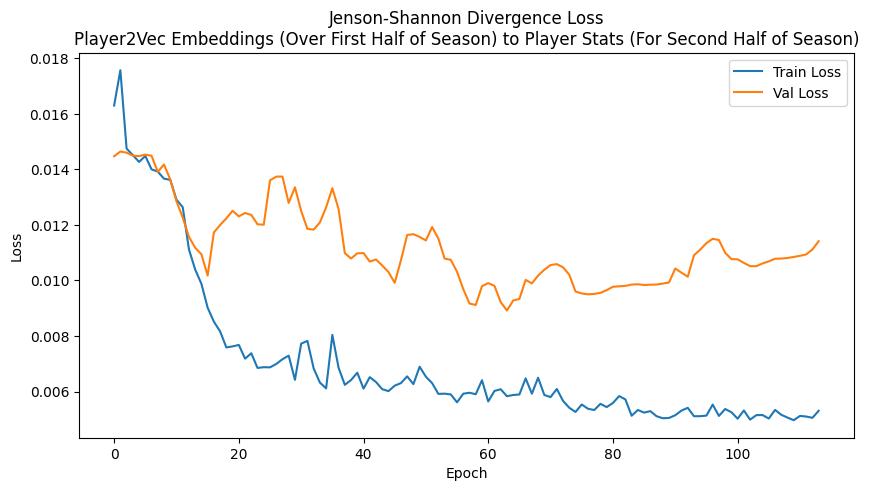

In [90]:
best_trial = trials.results[np.argmin([r["loss"] if "loss" in r else np.inf for r in trials.results])]
fig, ax = plot_losses(best_trial["train_losses"], best_trial["test_losses"])
# Save the figure
fig.savefig(
    f"../recursos_pdf/graficos/p2v_dist_model_oos_{N_MATCHES}_for_graph_{380 - N_MATCHES}_for_model_{len(input_cols)}_{n_epochs}_{best_trial['params']['lr']}_{best_trial['params']['scheduler']['scheduler']}_tuned.png"
)

best_trial

In [91]:
np.min(best_trial["test_losses"]), np.min(best_trial["train_losses"])

(0.008916404098272324, 0.004966359119862318)

In [ ]:
best_trial["model"]

In [ ]:
best_trial

In [74]:
from torchview import draw_graph

In [92]:
best_model = best_trial["model"]

x = torch.rand(1, len(input_cols))
model_graph = draw_graph(
    best_model,
    x,
    graph_name="p2v_dist_model",
    graph_dir="LR",
    save_graph=True,
    filename="../recursos_pdf/graficos/p2v_dist_model_H",
)

graph = model_graph.visual_graph

# Save the plot as pdf
graph.render("../recursos_pdf/graficos/p2v_dist_model_tuned_H", format="pdf")

graph

In [ ]:
best_model

In [ ]:
# save best_model

torch.save(
    best_model,
    f"p2v_dist_model_oos_{N_MATCHES}_for_graph_{380 - N_MATCHES}_for_model_{len(input_cols)}_{n_epochs}_{best_trial['params']['lr']}_{best_trial['params']['scheduler']['scheduler']}_tuned.pt",
)

In [94]:
# Eval best_model on the test set

best_model.eval()

criterion = custom_loss()

with torch.no_grad():
    y_pred = best_model(X_test)
    loss = criterion(y_pred, y_test)

eval_test_loss = loss.item()
eval_test_loss

0.014493363909423351

In [ ]:
best_trial.keys()

In [ ]:
best_trial["loss"], np.min(best_trial["train_losses"]), np.min(
    best_trial["test_losses"]
)

In [ ]:
len(best_trial["train_losses"])

In [ ]:
results = pd.DataFrame(
    {
        "train_loss": np.min(best_trial["train_losses"]),
        "val_loss": np.min(best_trial["test_losses"]),
        "test_loss": eval_test_loss,
    },
    index=[0],
)


print(results.to_latex())

In [ ]:
fig, ax = plot_losses(best_trial["train_losses"], best_trial["test_losses"])

# Draw dotted line on y=eval_test_loss
ax.axhline(eval_test_loss, color="red", linestyle="--", label="Eval Test Loss")

ax.legend()

fig.savefig(
    f"../recursos_pdf/graficos/p2v_dist_model_oos_{N_MATCHES}_for_graph_{380 - N_MATCHES}_for_model_{len(input_cols)}_{n_epochs}_{best_trial['params']['lr']}_{best_trial['params']['scheduler']['scheduler'].__name__}_tuned_eval_test_loss.png"
)

In [ ]:
best_trial["model"]

In [ ]:
"""
Best Architecture

Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=1024, out_features=32, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=32, out_features=128, bias=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): LeakyReLU(negative_slope=0.01)
  (14): Dropout(p=0.3, inplace=False)
  (15): Linear(in_features=128, out_features=1024, bias=True)
  (16): LeakyReLU(negative_slope=0.01)
  (17): Dropout(p=0.3, inplace=False)
  (18): Linear(in_features=1024, out_features=10, bias=True)
)

"""

best_params = best_trial["params"]

model = best_trial["model"].to("mps")

criterion = custom_loss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"],
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=best_params["scheduler"]["params"]["T_max"]
)

# early_stopping = best_params["early_stopping"]
early_stopping = True


n_epochs = 10000

iterator = tqdm(range(n_epochs))

train_losses = []
test_losses = []

X_train_val = torch.cat([X_train, X_val], axis=0).to("mps")
y_train_val = torch.cat([y_train, y_val], axis=0).to("mps")


wandb.init(
    project="td8",
    name=f"p2v_dist_model_oos_{N_MATCHES}_for_graph_{380 - N_MATCHES}_for_model_{len(input_cols)}_{n_epochs}_tuned",
    config={
        "p2v dims": len(input_cols),
        "n_epochs": n_epochs,
        "scheduler": f"{scheduler.__class__.__name__}",
        "architecture": str(model),
        **{
            f"scheduler_{k}": v
            for k, v in scheduler.__dict__.items()
            if not k.startswith("_")
        },
        **best_params,
    },
)

for epoch in iterator:
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_val)
    loss = criterion(y_pred, y_train_val)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if scheduler is not None:
        scheduler.step()

    if (
        early_stopping
        and len(test_losses) > 100
        and test_losses[-100] < test_losses[-1]
    ):
        break

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to("mps"))
        loss = criterion(y_pred, y_test.to("mps"))
        test_losses.append(loss.item())

    iterator.set_postfix(loss=loss.item())

    wandb.log({"train_loss": train_losses[-1], "test_loss": test_losses[-1]})

wandb.finish()

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_losses, label="train")
ax.plot(test_losses, label="test")

ax.legend()

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# ax.set_title("Jenson-Shannon Divergence Loss\nPlayer2Vec Embeddings (Over First Half of Season) to Player Stats (For Second Half of Season)")

np.argmin(test_losses), test_losses[np.argmin(test_losses)]

In [ ]:
torch.__version__

In [ ]:
# Save X_train, y_train, X_val, y_val, X_test, y_test
import os

# os.mkdir("td_data")

torch.save(X_train, "td_data/X_train.pt")
torch.save(y_train, "td_data/y_train.pt")
torch.save(X_val, "td_data/X_val.pt")
torch.save(y_val, "td_data/y_val.pt")
torch.save(X_test, "td_data/X_test.pt")
torch.save(y_test, "td_data/y_test.pt")

In [ ]:
# Save model
os.mkdir("td_models")
torch.save(
    best_trial["model"],
    f"td_models/p2v_dist_model_oos_{N_MATCHES}_for_graph_{380 - N_MATCHES}_for_model_{len(input_cols)}_{n_epochs}_tuned.pt",
)

## Comparisson to A-Priori

In [77]:
tp_ds_first = tp_ds[tp_ds["match_num"] < N_MATCHES]

player_stats_first = RandomVariablePSL.calculate_player_stats(
    tp_ds_first, EPL_Full_Data.get_player_ids()
)

flat_stats_df_first = pd.DataFrame(player_stats_first).T
flat_stats_df_first

mean       std       min       max
17733.0  losses_prob         0.443968  0.248075  0.000000  1.000000
         gains_prob          0.068588  0.105271  0.000000  0.500000
         shots_prob          0.014134  0.034556  0.000000  0.142857
         avg_pass_to_prob    0.049263  0.023008  0.000000  0.090909
         avg_pass_from_prob  0.094746  0.134128  0.011364  0.566414
...                               ...       ...       ...       ...
106458.0 losses_prob         0.000000  0.000000  0.000000  0.000000
         gains_prob          0.000000  0.000000  0.000000  0.000000
         shots_prob          0.000000  0.000000  0.000000  0.000000
         avg_pass_to_prob    0.000000  0.000000  0.000000  0.000000
         avg_pass_from_prob  0.000000  0.000000  0.000000  0.000000

[2605 rows x 4 columns]

In [78]:
# Count ammount of zeros in the dataset
section_first = tp_ds_first[[col for col in tp_ds_first.columns if "prob" in col]]
section_first = section_first.replace(0.0, np.nan)
section_first.isnull().sum().sum(), section_first.shape[0] * section_first.shape[
    1
], section_first.isnull().sum().sum() / (section_first.shape[0] * section_first.shape[1])

(25931, 71110, 0.3646603853185206)

In [79]:
section_last.isnull().sum().sum(), section_last.shape[0] * section_last.shape[
    1
], section_last.isnull().sum().sum() / (section_last.shape[0] * section_last.shape[1])

(25282, 69340, 0.36460917219498123)

In [80]:
# Check for data leakage in tp_ds_first vs tp_ds_last

for row_first, row_last in zip(tp_ds_first.iterrows(), tp_ds_last.iterrows()):
    if np.all(row_first[1] == row_last[1]):
        print(row_first[0], row_last[0])

In [81]:
dist_ds_first = []

for i, player_id in tqdm(enumerate(player_ids.astype(int))):
    if str(player_id) not in p2v_model.model.wv.index_to_key:
        continue
    emb = p2v_model.model.wv.get_vector(str(player_id))

    dist_ds_first.append(
        {
            "player_id": player_id,
            **{f"emb_{i}": emb[i] for i in range(len(emb))},
            "losses_prob_mean": flat_stats_df_first.loc[(player_id, "losses_prob")][
                "mean"
            ],
            "gains_prob_mean": flat_stats_df_first.loc[(player_id, "gains_prob")][
                "mean"
            ],
            "shots_prob_mean": flat_stats_df_first.loc[(player_id, "shots_prob")][
                "mean"
            ],
            "avg_pass_to_prob_mean": flat_stats_df_first.loc[
                (player_id, "avg_pass_to_prob")
            ]["mean"],
            "avg_pass_from_prob_mean": flat_stats_df_first.loc[
                (player_id, "avg_pass_from_prob")
            ]["mean"],
            "losses_prob_std": flat_stats_df_first.loc[(player_id, "losses_prob")][
                "std"
            ],
            "gains_prob_std": flat_stats_df_first.loc[(player_id, "gains_prob")]["std"],
            "shots_prob_std": flat_stats_df_first.loc[(player_id, "shots_prob")]["std"],
            "avg_pass_to_prob_std": flat_stats_df_first.loc[
                (player_id, "avg_pass_to_prob")
            ]["std"],
            "avg_pass_from_prob_std": flat_stats_df_first.loc[
                (player_id, "avg_pass_from_prob")
            ]["std"],
            # **{
            #     f"{d}_{s}_mean": flat_stats_df_first.loc[(player_id, s)]["mean"]
            #     for d, s in flat_stats_df_first.index
            # },
            # **{
            #     f"{d}_{s}_std": flat_stats_df_first.loc[(player_id, s)]["std"]
            #     for d, s in flat_stats_df_first.index
            # },
            # "name": EPL_Full_Data.epl_player_data.get_player_name(int(player_id)),
            # "position": EPL_Full_Data.epl_player_data.get_player_position(
            #     int(player_id)
            # ),
            # "team": EPL_Full_Data.get_player_team(int(player_id)),
        }
    )

dist_ds_first

522it [00:00, 1080.74it/s]


[{'player_id': 17733,
  'emb_0': -0.7772358,
  'emb_1': -0.82739365,
  'emb_2': -1.1085166,
  'emb_3': -1.3674924,
  'emb_4': 0.29804724,
  'emb_5': 0.10072183,
  'emb_6': 0.3333551,
  'emb_7': -0.25768927,
  'emb_8': -0.41519338,
  'emb_9': 1.1177084,
  'emb_10': -0.3047331,
  'emb_11': -0.12008282,
  'emb_12': 0.6120322,
  'emb_13': 0.21611778,
  'emb_14': -0.5046048,
  'emb_15': 0.2669434,
  'emb_16': 0.23370188,
  'emb_17': -1.2523266,
  'emb_18': 0.7469084,
  'emb_19': -2.0202281,
  'emb_20': 0.48876593,
  'emb_21': 1.67743,
  'emb_22': -0.59618044,
  'emb_23': -0.092930004,
  'emb_24': -0.62694,
  'emb_25': 1.2188017,
  'emb_26': 1.2672791,
  'emb_27': 1.2358103,
  'emb_28': -0.46536264,
  'emb_29': -1.0884738,
  'emb_30': -0.23690185,
  'emb_31': -0.7723991,
  'emb_32': 1.024458,
  'emb_33': -0.8763858,
  'emb_34': -0.7981867,
  'emb_35': 0.2050004,
  'emb_36': -1.7812711,
  'emb_37': 1.0273848,
  'emb_38': 0.4147971,
  'emb_39': 0.79532295,
  'emb_40': -0.30189267,
  'emb_41': 

In [82]:
dist_df_first = pd.DataFrame(dist_ds_first).fillna(0)
dist_df_first

,player_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,losses_prob_mean,gains_prob_mean,shots_prob_mean,avg_pass_to_prob_mean,avg_pass_from_prob_mean,losses_prob_std,gains_prob_std,shots_prob_std,avg_pass_to_prob_std,avg_pass_from_prob_std
0,17733,-0.777236,-0.827394,-1.108517,-1.367492,0.298047,0.100722,0.333355,-0.257689,-0.415193,...,0.443968,0.068588,0.014134,0.049263,0.094746,0.248075,0.105271,0.034556,0.023008,0.134128
1,19524,-0.197837,-0.086181,-0.270440,-1.541033,-0.647647,-0.241033,0.453066,0.031506,-0.255329,...,0.425452,0.075318,0.008206,0.051486,0.077967,0.289456,0.101895,0.025480,0.026430,0.104752
2,15943,-0.517551,-0.757132,-0.763548,-1.837337,-0.012568,-0.121198,0.069757,0.380025,-0.557337,...,0.477697,0.044123,0.007378,0.043676,0.074749,0.285544,0.068511,0.022216,0.026113,0.119384
3,20467,0.059738,-0.997576,0.113130,-1.064545,-0.540343,0.934796,0.413289,0.402721,-0.467876,...,0.449159,0.036660,0.007728,0.044589,0.108734,0.375703,0.066267,0.022122,0.034495,0.129070
4,80254,-0.975766,0.388918,-0.581350,-1.586341,-0.943228,-0.776151,0.702808,0.640583,0.382979,...,0.425374,0.050768,0.006378,0.051659,0.074214,0.272889,0.084422,0.019814,0.025063,0.087842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,103912,0.006345,-0.008638,-0.014481,0.010936,0.007477,-0.001648,-0.004203,-0.005378,0.014359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
517,92790,0.007155,-0.004274,-0.010602,-0.012365,0.013518,-0.006678,0.006705,-0.007051,0.007838,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
518,94738,-0.014298,0.000599,0.004172,-0.001862,0.005824,0.001945,-0.000426,-0.003270,-0.014652,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
519,76227,0.014679,0.000733,-0.000395,0.001490,-0.000436,0.011961,-0.007276,-0.000852,-0.013699,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
# Find y_test values on dist_df and regain index

player_ids_test = []

for arr in y_test:
    for i, row in dist_df.iterrows():
        if np.allclose(arr, row[output_cols].values):
            player_ids_test.append(row["player_id"])
            break

player_ids_test

[4396.0,
 101178.0,
 78830.0,
 77454.0,
 13164.0,
 4396.0,
 114312.0,
 17468.0,
 16210.0,
 4396.0,
 90255.0,
 18987.0,
 17339.0,
 55829.0,
 39221.0,
 77305.0,
 1827.0,
 40204.0,
 41328.0,
 39215.0,
 50471.0,
 11378.0,
 42996.0,
 49318.0,
 28146.0,
 16234.0,
 15943.0,
 8595.0,
 4396.0,
 27341.0,
 125510.0,
 42425.0,
 46479.0,
 38530.0,
 78315.0,
 17336.0,
 5609.0,
 37915.0,
 39529.0,
 1212.0,
 15749.0,
 37869.0,
 6286.0,
 12679.0,
 20208.0,
 28554.0,
 4098.0,
 7551.0,
 40146.0,
 6219.0,
 49384.0,
 19556.0,
 4396.0,
 43191.0,
 20452.0,
 28468.0,
 11735.0,
 54771.0,
 49724.0,
 4396.0,
 4396.0,
 55909.0,
 4396.0,
 60551.0,
 51940.0,
 41727.0,
 39242.0,
 7631.0,
 28301.0,
 63426.0,
 55604.0,
 18277.0,
 9007.0,
 8758.0,
 10949.0,
 49305.0,
 4255.0,
 28491.0,
 78108.0,
 88894.0,
 19569.0,
 17906.0,
 49982.0,
 27450.0,
 4396.0,
 38411.0,
 19714.0,
 56069.0,
 74235.0,
 115556.0,
 4396.0,
 11911.0,
 15944.0,
 38580.0,
 57328.0,
 41493.0,
 9493.0,
 59940.0,
 8380.0,
 48759.0,
 8742.0,
 18753.0,
 

In [84]:
y_last = pd.DataFrame(
    y_test, columns=output_cols, index=np.array(player_ids_test).astype(int)
)
y_last

,losses_prob_mean,gains_prob_mean,shots_prob_mean,avg_pass_to_prob_mean,avg_pass_from_prob_mean,losses_prob_std,gains_prob_std,shots_prob_std,avg_pass_to_prob_std,avg_pass_from_prob_std
4396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101178,0.388661,0.054398,0.038397,0.044510,0.049302,0.209232,0.084565,0.082545,0.024523,0.031347
78830,0.560551,0.024194,0.041667,0.036162,0.031327,0.100180,0.048387,0.083333,0.015420,0.022371
77454,0.468640,0.090865,0.000000,0.048305,0.109173,0.372299,0.255808,0.000000,0.033845,0.117727
13164,0.559200,0.029221,0.000000,0.031808,0.029319,0.266919,0.076295,0.000000,0.020392,0.028903
...,...,...,...,...,...,...,...,...,...,...
8742,0.537500,0.022917,0.000000,0.042045,0.025123,0.047871,0.026680,0.000000,0.004352,0.023217
18753,0.525316,0.022727,0.004785,0.042718,0.116217,0.305139,0.075378,0.015869,0.028025,0.150852
4396,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3289,0.657500,0.036494,0.006423,0.027418,0.109745,0.298510,0.124852,0.022065,0.024812,0.204566


In [85]:
y_first = dist_df_first[
    [col for col in dist_df_first.columns if "prob" in col or col == "player_id"]
]

# Set player_id as index
y_first = y_first.set_index("player_id")
y_first = y_first.loc[y_last.index]
y_first

,losses_prob_mean,gains_prob_mean,shots_prob_mean,avg_pass_to_prob_mean,avg_pass_from_prob_mean,losses_prob_std,gains_prob_std,shots_prob_std,avg_pass_to_prob_std,avg_pass_from_prob_std
4396,0.641606,0.000000,0.000000,0.032581,0.161135,0.338232,0.000000,0.000000,0.030748,0.221323
101178,0.350523,0.012190,0.011058,0.052356,0.075263,0.260331,0.023432,0.030508,0.026395,0.105931
78830,0.531250,0.000000,0.000000,0.042614,0.033236,0.044194,0.000000,0.000000,0.004018,0.013968
77454,0.525385,0.048531,0.014355,0.041842,0.049632,0.202464,0.044085,0.025497,0.018194,0.024997
13164,0.522562,0.014988,0.002592,0.039531,0.044736,0.289582,0.041074,0.007854,0.025696,0.034728
...,...,...,...,...,...,...,...,...,...,...
8742,0.343434,0.000000,0.000000,0.059688,0.046204,0.017495,0.000000,0.000000,0.001590,0.013136
18753,0.548844,0.051850,0.016648,0.037228,0.095157,0.267857,0.074499,0.045151,0.023112,0.155159
4396,0.641606,0.000000,0.000000,0.032581,0.161135,0.338232,0.000000,0.000000,0.030748,0.221323
3289,0.575252,0.048112,0.012521,0.037475,0.043100,0.224252,0.115755,0.037795,0.020215,0.031423


In [86]:
criterion = custom_loss()

# criterion on y_first and y_last by index match

apriori_loss = criterion(
    torch.tensor(y_first.values, dtype=torch.float32),
    torch.tensor(y_last.values, dtype=torch.float32),
)

apriori_loss

tensor(0.0353)

In [96]:
1 - (eval_test_loss / apriori_loss)

tensor(0.5899)